# Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from pandas.tseries.offsets import BMonthBegin, BMonthEnd, BusinessDay
import pandas_market_calendars as mcal

# Momentum studies based on the book "Dual Momentum Investing: An Innovative Strategy for Higher Returns with Lower Risk", by Gary Antonacci.

The aim of this study was to use the core concept of momentum from the book (mainly trailing X months positive return) applied to brazilian market .

In [2]:
# Dual momentum algorithm proposed by the book
Image(url="images/GEM_rules.jpg", width=500, height=500)

# Data preparation (Brazilian index BOVESPA, ^BVSP yfinance ticker)

## Downloading data

In [3]:
df = yf.download("^BVSP", interval="1mo")

[*********************100%***********************]  1 of 1 completed


## Drop unnecessary data

In [4]:
df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)

## Defining trailling month positive return criteria

In [5]:
trailing_months = 12
df["ttm"] = df["Adj Close"].pct_change(periods=trailing_months)

## Creating return column

In [6]:
df["monthly_pct"] = df["Adj Close"].pct_change()

In [7]:
df.head(10)

,Adj Close,ttm,monthly_pct
Date,,,
1993-05-01,34.900002,NaN,NaN
1993-06-01,53.700001,NaN,0.538682
1993-07-01,65.599998,NaN,0.221601
1993-08-01,96.400002,NaN,0.469512
1993-09-01,146.600006,NaN,0.520747
1993-10-01,184.399994,NaN,0.257844
1993-11-01,274.000000,NaN,0.485900
1993-12-01,375.500000,NaN,0.370438
1994-01-01,740.599976,NaN,0.972304


## Creating boolean auxiliary column to determine if the trailing X-months returns of the index was positive (1) or not (0)

In [8]:
df[str(trailing_months)+"_LB"] = df.apply(lambda x: 1 if x["ttm"] > 0 else 0, axis=1)

In [9]:
df

,Adj Close,ttm,monthly_pct,12_LB
Date,,,,
1993-05-01,34.900002,NaN,NaN,0
1993-06-01,53.700001,NaN,5.386819e-01,0
1993-07-01,65.599998,NaN,2.216014e-01,0
1993-08-01,96.400002,NaN,4.695123e-01,0
1993-09-01,146.600006,NaN,5.207469e-01,0
...,...,...,...,...
2022-07-01,103165.000000,-0.153004,4.691401e-02,0
2022-08-01,109523.000000,-0.077942,6.162943e-02,0
2022-09-01,110037.000000,-0.008488,4.693078e-03,0


## Plotting the distribution of the monthly returns and calculating its skew.

Skew of the returns distribution: 2.27 



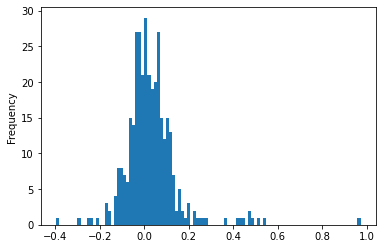

In [10]:
print("Skew of the returns distribution:", round(df["monthly_pct"].skew(), 2), "\n")
df["monthly_pct"].plot(kind="hist", bins=100);

In [11]:
#droping NaN rows
df.dropna(inplace=True)
df

,Adj Close,ttm,monthly_pct,12_LB
Date,,,,
1994-05-01,2467.199951,69.693405,4.441582e-01,1
1994-06-01,3623.199951,66.471134,4.685474e-01,1
1994-07-01,4201.299805,63.044206,1.595551e-01,1
1994-08-01,5329.500000,54.285269,2.685360e-01,1
1994-09-01,5484.000000,36.407911,2.898959e-02,1
...,...,...,...,...
2022-07-01,103165.000000,-0.153004,4.691401e-02,0
2022-08-01,109523.000000,-0.077942,6.162943e-02,0
2022-09-01,110037.000000,-0.008488,4.693078e-03,0


## Creating returns of the momentum criteria using the auxiliary boolean column

In [12]:
##Creating returns of the momentum criteria using the auxiliary boolean column
# first return of the series = 0
mom_ret = [0]
# rules to account return after trailing months positive return turns/stay positive (1) or negative
for i in range(1, len(df)):
    #accounting return when momentum rules stay positive
    if df[str(trailing_months)+"_LB"].iloc[i-1] == 1 and df[str(trailing_months)+"_LB"].iloc[i] == 1:
        mom_ret.append(df["monthly_pct"].iloc[i])
    #accounting return when momentum rules turns negative
    if df[str(trailing_months)+"_LB"].iloc[i-1] == 1 and df[str(trailing_months)+"_LB"].iloc[i] == 0:
        mom_ret.append(df["monthly_pct"].iloc[i])
    #accounting return when momentum rules stay negative
    if df[str(trailing_months)+"_LB"].iloc[i-1] == 0 and df[str(trailing_months)+"_LB"].iloc[i] == 0:
        mom_ret.append(0)
    #accounting return when momentum rules turn positive
    if df[str(trailing_months)+"_LB"].iloc[i-1] == 0 and df[str(trailing_months)+"_LB"].iloc[i] == 1:
        mom_ret.append(0)
#assignin new momentum return column to the dataset
df[str(trailing_months)+"tm_ret"] = mom_ret

# df["momentum_ret"] = (df.apply(lambda x: x["monthly_pct"] if x["tLB"] > 0 else 0, axis=1)).shift(-1)

In [13]:
df.dropna(inplace=True)

# Plotting the result of the momentum strategy vs. the index itself

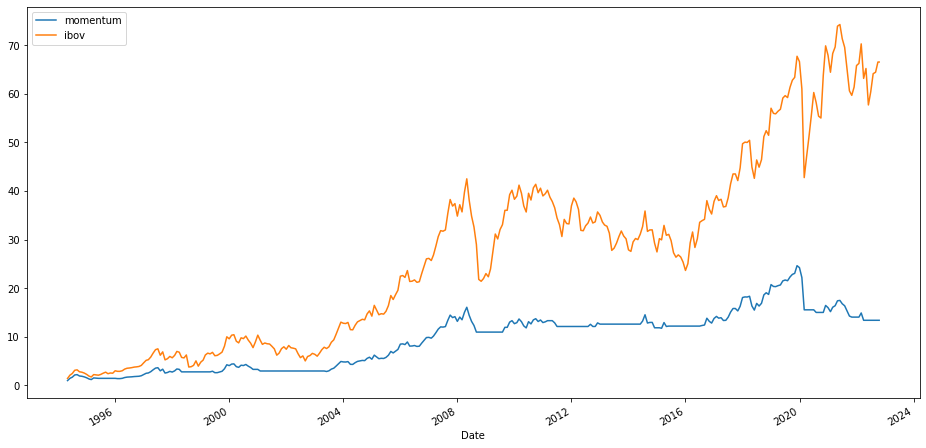

In [14]:
plt.figure(figsize=(16,8))
np.cumprod(1 + df[str(trailing_months)+"tm_ret"]).plot(label="momentum")
np.cumprod(1 + df["monthly_pct"]).plot(label="ibov")
plt.legend();

## Plotting the monthly returns of the momentum investing approach along with its skew.

Skew of the returns distribution: 0.97 



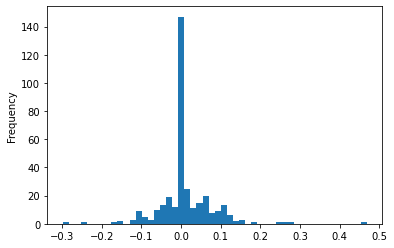

In [15]:
print("Skew of the returns distribution:", round(df[str(trailing_months)+"tm_ret"].skew(), 2), "\n")
df[str(trailing_months)+"tm_ret"].plot(kind="hist", bins=50);

# Creating function to wrangle and calculate data for X positive trailing months returns

In [16]:
def wrangle_data(index, trailing_months):
    df = yf.download(index, interval="1mo")
    #creating trailing x months return
    df[str(trailing_months)+"_tm_ret"] = df["Adj Close"].pct_change(periods=trailing_months)
    #creating monthly %change
    df["monthly_pct"] = df["Adj Close"].pct_change()
    #Creating boolean auxiliary column to determine if the trailing X-months returns of the index was positive (1) or not (0)
    df[str(trailing_months)+"_LB"] = df.apply(lambda x: 1 if x[str(trailing_months)+"_tm_ret"] > 0 else 0, axis=1)
    #drop unnecessary columns
    df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
    #drop NA rows
    df.dropna(inplace=True)
    #Creating returns of the momentum criteria using the auxiliary boolean column
    mom_ret = [0]
    for i in range(1, len(df)):
        if df[str(trailing_months)+"_LB"].iloc[i-1] == 1 and df[str(trailing_months)+"_LB"].iloc[i] == 1:
            mom_ret.append(df["monthly_pct"].iloc[i])
        if df[str(trailing_months)+"_LB"].iloc[i-1] == 1 and df[str(trailing_months)+"_LB"].iloc[i] == 0:
            mom_ret.append(df["monthly_pct"].iloc[i])
        if df[str(trailing_months)+"_LB"].iloc[i-1] == 0 and df[str(trailing_months)+"_LB"].iloc[i] == 0:
            mom_ret.append(0)
        if df[str(trailing_months)+"_LB"].iloc[i-1] == 0 and df[str(trailing_months)+"_LB"].iloc[i] == 1:
            mom_ret.append(0)
    df[str(trailing_months)+"tm_ret"] = mom_ret

    return df[str(trailing_months)+"tm_ret"]

# Creating function to plot X positive trailing month returns

In [17]:
def plot_returns(ret_df):
    #calculating cumulative return for momentum strategy
    y = np.cumprod(1 + ret_df)
    #ploting cumulative return for momentum strategy
    plt.plot(y, label=ret_df.name)
    plt.legend()

    return

# Creating Dataframe for benchmark + trailing positive return momentum strategies

In [18]:
#creating dataframe for benchmark returns
data = yf.download("^BVSP", interval="1mo", start="2002-01-01", end="2020-12-31")["Adj Close"].rename("IBOVESPA").pct_change().to_frame()
#including columns for X trailing positive returns momentum strategy
for i in range(2, 13):
    data[str(i) + "_LB"] = wrangle_data("^BVSP", i)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
data = data["2003-01-01":"2020-12-31"]
data

,IBOVESPA,2_LB,3_LB,4_LB,5_LB,6_LB,7_LB,8_LB,9_LB,10_LB,11_LB,12_LB
Date,,,,,,,,,,,,
2003-01-01,-0.029020,-0.029020,-0.029020,-0.029020,-0.029020,-0.029020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-02-01,-0.060324,-0.060324,-0.060324,-0.060324,-0.060324,-0.060324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-03-01,0.096586,0.000000,0.000000,0.096586,0.096586,0.000000,0.096586,0.000000,0.000000,0.000000,0.000000,0.000000
2003-04-01,0.113802,0.113802,0.113802,0.113802,0.113802,0.113802,0.113802,0.113802,0.113802,0.000000,0.000000,0.000000
2003-05-01,0.068886,0.068886,0.068886,0.068886,0.068886,0.068886,0.068886,0.068886,0.068886,0.068886,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-0.034427,-0.034427,-0.034427,-0.034427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034427,-0.034427
2020-09-01,-0.047963,-0.047963,-0.047963,-0.047963,-0.047963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-10-01,-0.006881,0.000000,0.000000,-0.006881,-0.006881,-0.006881,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Ploting benchmark and X trailing months positive returns momentum strategies

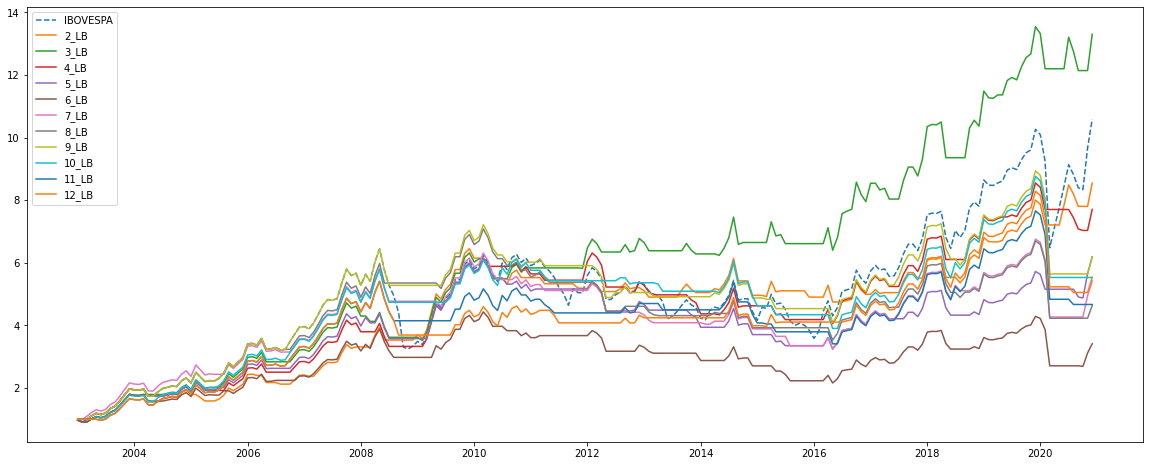

In [20]:
#droping NaN rows
data.dropna(inplace=True)
#creating chart specifying figsize
plt.figure(figsize=(20,8))
#loop for ploting all trailing positive returns momentum strategy
for ret in data:
    #ploting benchmark return with different linestyle
    if ret == "IBOVESPA":
        plt.plot(np.cumprod(1 + data[ret]), ls = "--", label="IBOVESPA")
    #plotting X trailing positive returns momentum strategy
    else:
        plot_returns(data[ret])

# Calculating mean return for each lookback period strategy and its benchmark (IBOVESPA)

In [21]:
round(data.mean(), 4).sort_values(ascending=False)*100

IBOVESPA    1.33
3_LB        1.33
2_LB        1.11
4_LB        1.08
9_LB        0.99
5_LB        0.98
7_LB        0.94
10_LB       0.94
12_LB       0.94
11_LB       0.86
8_LB        0.85
6_LB        0.72
dtype: float64

# Calculating standard deviation for each lookback period strategy and its benchmark (IBOVESPA)

In [22]:
round(data.std(), 4).sort_values(ascending=False)*100

IBOVESPA    6.78
7_LB        5.51
6_LB        5.50
9_LB        5.37
11_LB       5.34
12_LB       5.34
10_LB       5.31
8_LB        5.26
5_LB        5.16
4_LB        5.09
3_LB        4.98
2_LB        4.89
dtype: float64

# Importing Brazilian central bank monthly risk free rate

In [23]:
url_bc = "http://api.bcb.gov.br/dados/serie/bcdata.sgs.4391/dados?formato=json"
cdi_df = pd.read_json(url_bc)
cdi_df["data"] = pd.to_datetime(cdi_df["data"], format="%d/%m/%Y")
cdi_df.set_index("data", inplace=True)
cdi_df.rename_axis(None, inplace=True)
cdi_df.head(5)

,valor
1986-03-01,0.87
1986-04-01,1.37
1986-05-01,1.32
1986-06-01,1.57
1986-07-01,2.23


In [24]:
# sorted dataframe to rank strategies based on sharpe ratio
pd.DataFrame((data.values*100 - cdi_df.to_period("M")["2003-01":"2020-12"].values)/(data.std().values*100), index=data.index, columns=data.columns).mean().sort_values(ascending=False)

3_LB        0.083326
IBOVESPA    0.062200
2_LB        0.041763
4_LB        0.032520
9_LB        0.015576
5_LB        0.012964
12_LB       0.005651
7_LB        0.005280
10_LB       0.005221
11_LB      -0.009292
8_LB       -0.010865
6_LB       -0.033868
dtype: float64

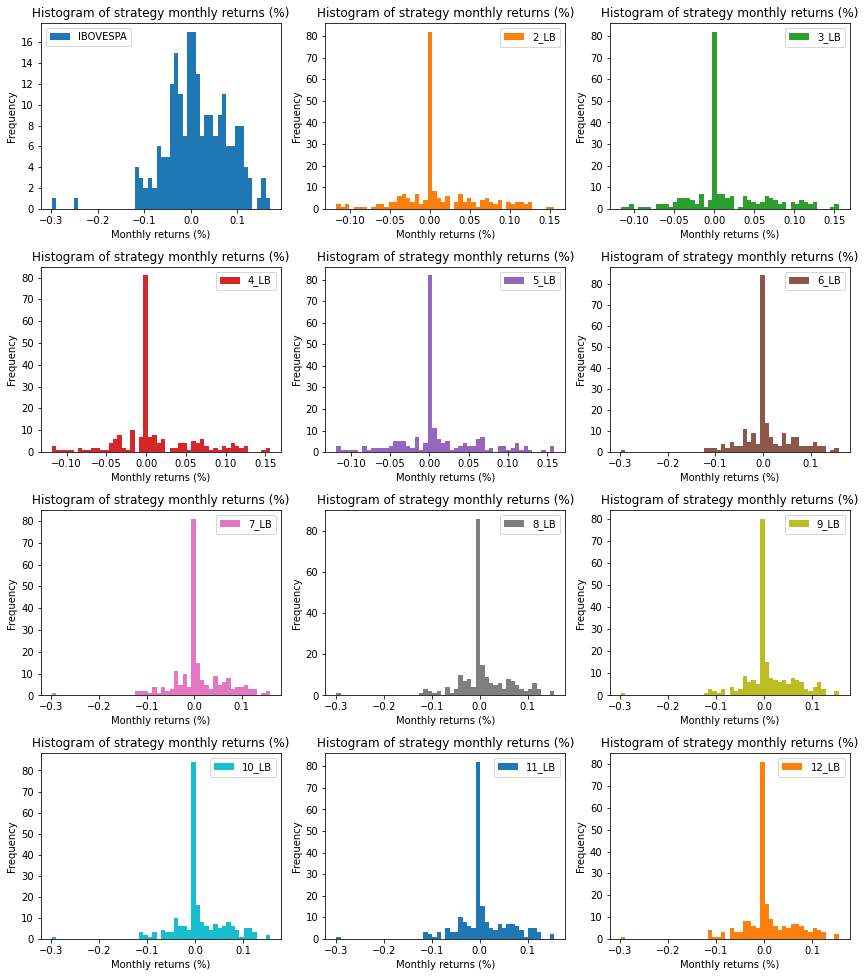

In [40]:
# plotting histogram of monthly returns for each strategy
colors = plt.rcParams["axes.prop_cycle"]()
plt.figure(figsize=(12, 20), layout="tight")
for i, strategy in enumerate(data):
    c = next(colors)["color"]
    plt.subplot(6, 3, i + 1)
    plt.hist(x = data[strategy], bins=50, label=strategy, color=c)
    plt.xlabel("Monthly returns (%)")
    plt.ylabel("Frequency")
    plt.title("Histogram of strategy monthly returns (%)")
    plt.legend();


In [47]:
# monte-carlo method to determine probabilities of maximum drawdown in a 5-year period
max_dd = np.array([])
for n in range(50_000):
    sim_ret = np.random.choice(data["IBOVESPA"].to_numpy().reshape(-1), size = 60, replace = True)

    sim_val = (1 + sim_ret).cumprod()

    max_val = np.maximum.accumulate(sim_val)

    max_dd = np.append(max_dd, np.max((max_val - sim_val)/max_val)*100)

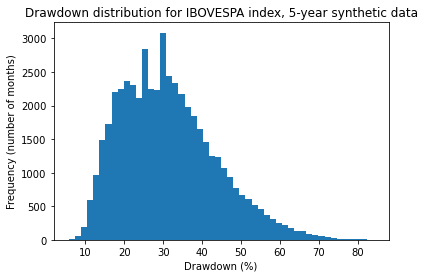

In [48]:
# plotting histogram of maximum drwadowns
plt.hist(max_dd, bins=50)
plt.title("Drawdown distribution for IBOVESPA index, 5-year synthetic data")
plt.xlabel("Drawdown (%)")
plt.ylabel("Frequency (number of months)");

In [53]:
# finding the probability of drawdown being higher than x%
print("50% probability, DD will be higher than " + str(round(np.median(max_dd), 2)) + "%")
print("25% probability, DD will be higher than " + str(round(np.percentile(max_dd, 75), 2)) + "%")
print("5% probability, DD will be higher than " + str(round(np.percentile(max_dd, 95), 2)) + "%")

50% probability, DD will be higher than 29.9%
25% probability, DD will be higher than 38.68%
5% probability, DD will be higher than 53.99%
